### Model Training

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unrar x '/content/drive/MyDrive/EarVN1.0 dataset.rar'

Streaming output truncated to the last 5000 lines.
Extracting  EarVN1.0 dataset/Images/134.Minh_Tr/134 (96).jpg              80%  OK 
Extracting  EarVN1.0 dataset/Images/134.Minh_Tr/134 (97).jpg              80%  OK 
Extracting  EarVN1.0 dataset/Images/134.Minh_Tr/134 (98).jpg              80%  OK 
Extracting  EarVN1.0 dataset/Images/134.Minh_Tr/134 (99).jpg              80%  OK 
Creating    EarVN1.0 dataset/Images/135.Minh_T                        OK
Extracting  EarVN1.0 dataset/Images/135.Minh_T/135 (1).jpg                80%  OK 
Extracting  EarVN1.0 dataset/Images/135.Minh_T/135 (10).jpg               80%  OK 
Extracting  EarVN1.0 dataset/Images/135.Minh_T/135 (100).jpg              80%  OK 
Extracting  EarVN1.0 dataset/Images/135.Minh_T/135 (101).jpg              80%  OK 
Extracting  EarVN1.0 dataset/Images/135.Minh_T/135 (102).jpg              80%  OK 
Extracting  EarVN1.0 dataset/Images/135.Minh_T/1

In [3]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [4]:
DATA_DIR = '/content/EarVN1.0 dataset/Images/'
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 64

In [5]:
train_val_ds = tf.keras.utils.image_dataset_from_directory(
  DATA_DIR,
  validation_split=0.15,
  label_mode='int',
  subset="training",
  seed=999,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

Found 28412 files belonging to 164 classes.
Using 24151 files for training.


In [6]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  DATA_DIR,
  validation_split=0.15,
  label_mode='int',
  subset="validation",
  seed=999,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

Found 28412 files belonging to 164 classes.
Using 4261 files for validation.


In [7]:
train_val_batches = tf.data.experimental.cardinality(train_val_ds)
train_val_batches

<tf.Tensor: shape=(), dtype=int64, numpy=378>

In [8]:
TOTAL_TRAIN_VAL = len(train_val_ds)
print(TOTAL_TRAIN_VAL)
train_ds = train_val_ds.take(int(8 * train_val_batches / 10))
val_ds = train_val_ds.skip(int(8 * train_val_batches / 10))
print(len(train_ds))
print(len(val_ds))

378
302
76


In [9]:
train_ds

<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [11]:
base_model_MobileNetV3Large = tf.keras.applications.MobileNetV3Large(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

12683000/12683000 [==============================] - 0s 0us/step


In [13]:
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, GlobalAveragePooling2D, GlobalMaxPooling2D

model = tf.keras.Sequential()
model.add(base_model_MobileNetV3Large)
model.add(GlobalMaxPooling2D())
model.add(Dense(4096, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(164, activation = 'softmax'))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Function  (None, 7, 7, 960)         2996352   
 al)                                                             
                                                                 
 global_max_pooling2d (Glob  (None, 960)               0         
 alMaxPooling2D)                                                 
                                                                 
 dense (Dense)               (None, 4096)              3936256   
                                                                 
 dropout (Dropout)           (None, 4096)              0         
                                                                 
 dense_1 (Dense)             (None, 164)               671908    
                                                                 
Total params: 7604516 (29.01 MB)
Trainable params: 75801

In [15]:
from tensorflow.keras import optimizers, losses
model.compile(optimizer=optimizers.Adam(learning_rate=3e-4), loss='sparse_categorical_crossentropy', metrics='accuracy')

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint
mc = ModelCheckpoint(
    filepath='./best_mobilenetv3large_model_epoch={epoch:02d}_acc={val_accuracy:0.4f}.h5',
    monitor="val_accuracy",
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    save_freq='epoch'
)

In [18]:
results = model.fit(train_ds, validation_data=val_ds, epochs=50, batch_size=64, callbacks=[mc])

Epoch 1/50
302/302 [==============================] - ETA: 0s - loss: 4.8093 - accuracy: 0.0927
Epoch 1: val_accuracy improved from -inf to 0.06158, saving model to ./best_mobilenetv3large_model_epoch=01_acc=0.0616.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


302/302 [==============================] - 134s 317ms/step - loss: 4.8093 - accuracy: 0.0927 - val_loss: 5.7374 - val_accuracy: 0.0616
Epoch 2/50
302/302 [==============================] - ETA: 0s - loss: 2.3423 - accuracy: 0.4048
Epoch 2: val_accuracy improved from 0.06158 to 0.18661, saving model to ./best_mobilenetv3large_model_epoch=02_acc=0.1866.h5
302/302 [==============================] - 95s 314ms/step - loss: 2.3423 - accuracy: 0.4048 - val_loss: 4.7379 - val_accuracy: 0.1866
Epoch 3/50
302/302 [==============================] - ETA: 0s - loss: 1.0866 - accuracy: 0.6977
Epoch 3: val_accuracy improved from 0.18661 to 0.35061, saving model to ./best_mobilenetv3large_model_epoch=03_acc=0.3506.h5
302/302 [==============================] - 113s 374ms/step - loss: 1.0866 - accuracy: 0.6977 - val_loss: 3.3841 - val_accuracy: 0.3506
Epoch 4/50
302/302 [==============================] - ETA: 0s - loss: 0.4766 - accuracy: 0.8580
Epoch 4: val_accuracy improved from 0.35061 to 0.46589, sa

In [20]:
predictions = []
y_true = []
for img, labels in test_ds:
    predictions.extend(model.predict_on_batch(img))
    y_true.extend(labels.numpy())
y_true = np.array(y_true)

In [21]:
y_pred = np.argmax(predictions, axis=1)

In [22]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.93      0.80      0.86        50
           1       0.89      0.79      0.84        39
           2       0.62      0.88      0.72        24
           3       0.90      0.84      0.87        31
           4       1.00      0.82      0.90        34
           5       0.81      0.49      0.61        35
           6       1.00      0.87      0.93        23
           7       0.91      0.77      0.83        26
           8       0.78      0.89      0.83        35
           9       0.92      0.86      0.89        28
          10       0.95      0.87      0.91        23
          11       0.90      0.97      0.93        29
          12       0.93      0.58      0.72        24
          13       0.70      0.82      0.76        17
          14       0.90      0.79      0.84        34
          15       0.84      0.93      0.88        28
          16       0.76      0.96      0.85        23
          17       0.82    

In [23]:
history = results.history

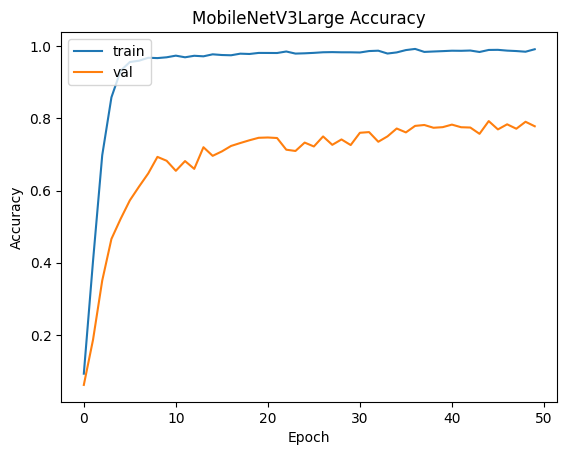

In [24]:
from matplotlib import pyplot as plt

plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('MobileNetV3Large Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

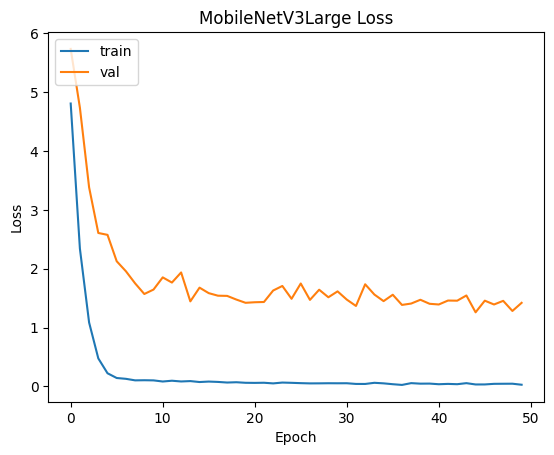

In [25]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('MobileNetV3Large Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()